### Variables
+ I = discrete state
+ O = observation
+ t = time
### Filter
$$
Pr(I_{t} \mid O_{1:t}) \propto Pr(O_t \mid I_{t}, O_{1:t-1}) \sum_{I_{t-1}} Pr(I_{t} \mid I_{t-1}) Pr(I_{t-1} \mid O_{1:t-1})
$$
### Smoother
$$
Pr(I_{t} \mid O_{1:T}) = Pr(I_t \mid O_{1:t}) \sum_{I_{t+1}} \frac{Pr(I_{t+1} \mid I_{t})}{Pr(I_{t+1} \mid O_{1:t})} Pr(I_{t+1} \mid O_{1:T})
$$

In [ ]:
import numpy as np

initial_conditions = np.asarray([0.2, 0.8])
transition_matrix = np.asarray([[0.5, 0.5], [0.3, 0.7]])
emission_matrix = np.asarray([[0.3, 0.7], [0.8, 0.2]])

observations = np.asarray(["N", "N", "N", "N", "N", "E", "E", "N", "N", "N"])
observations_ind = np.asarray([0 if o == "N" else 1 for o in observations])


In [ ]:
# initial_conditions = np.asarray([1.0, 0.0, 0.0])
# transition_matrix = np.asarray([[0.0, 0.5, 0.5], [0.0, 0.9, 0.1], [0.0, 0.0, 1.0]])
# emission_matrix = np.asarray([[0.5, 0.5], [0.9, 0.1], [0.1, 0.9]])
# observations = np.asarray([2, 3, 3, 2, 2, 2, 3, 2, 3])
# observations_ind = np.asarray([0 if o == 2 else 1 for o in observations])


In [ ]:
# initial_conditions = np.asarray([0.5, 0.5])
# transition_matrix = np.asarray([[0.7, 0.3], [0.3, 0.7]])
# emission_matrix = np.asarray([[0.9, 0.1], [0.2, 0.8]])
# observations = np.asarray(
#     ["umbrella", "umbrella", "no umbrella", "umbrella", "umbrella"]
# )
# observations_ind = np.asarray([0 if o == "umbrella" else 1 for o in observations])


In [ ]:
from src.hmm import forward, correction_smoothing

causal_posterior, data_log_likelihood, scaling = forward(
    initial_conditions, observations_ind, emission_matrix, transition_matrix
)

causal_posterior


In [ ]:
acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)
acausal_posterior


In [ ]:
from src.hmm import parallel_smoothing, get_acausal_posterior_from_parallel_smoothing

backward_posterior = parallel_smoothing(
    initial_conditions, observations_ind, emission_matrix, transition_matrix, scaling
)
get_acausal_posterior_from_parallel_smoothing(causal_posterior, backward_posterior)


In [ ]:
n_states = len(initial_conditions)
n_time = len(observations_ind)

likelihood = emission_matrix[:, observations_ind].T

new_transition_matrix = np.zeros((n_states, n_states))
for time_ind in range(n_time - 1):
    for from_state in range(n_states):
        for to_state in range(n_states):
            new_transition_matrix[from_state, to_state] += (
                causal_posterior[time_ind, from_state]
                * transition_matrix[from_state, to_state]
                * likelihood[time_ind + 1, to_state]
                * backward_posterior[time_ind + 1, to_state]
            ) / (
                (
                    causal_posterior[time_ind, to_state]
                    * backward_posterior[time_ind, to_state]
                    * scaling[time_ind]
                )
                + np.spacing(1)
            )

new_transition_matrix /= new_transition_matrix.sum(axis=1, keepdims=True)
new_transition_matrix


In [ ]:
new_transition_matrix = np.sum(
    (
        causal_posterior[:-1, :, np.newaxis]
        * likelihood[1:, np.newaxis, :]
        * backward_posterior[1:, np.newaxis, :]
        * transition_matrix[np.newaxis]
    )
    / (
       scaling[:-1, np.newaxis, np.newaxis]
    ),
    axis=0,
)
new_transition_matrix /= new_transition_matrix.sum(axis=1, keepdims=True)
new_transition_matrix


In [ ]:


new_transition_matrix = np.empty((n_states, n_states))

for from_state in range(n_states):
    for to_state in range(n_states):
        new_transition_matrix[from_state, to_state] = np.sum(
            causal_posterior[:-1, from_state]
            * likelihood[1:, to_state]
            * backward_posterior[1:, to_state]
            * transition_matrix[from_state, to_state]
        )

new_transition_matrix /= np.exp(data_log_likelihood)

new_transition_matrix /= new_transition_matrix.sum(axis=1, keepdims=True)
new_transition_matrix


In [ ]:


new_transition_matrix = np.empty((n_states, n_states))

for from_state in range(n_states):
    for to_state in range(n_states):
        new_transition_matrix[from_state, to_state] = np.sum(
            causal_posterior[:-1, from_state]
            * likelihood[1:, to_state]
            * acausal_posterior[1:, to_state]
            * transition_matrix[from_state, to_state]
            / (causal_posterior[1:, to_state] + np.spacing(1))
        )
        
new_transition_matrix /= new_transition_matrix.sum(axis=1, keepdims=True)
new_transition_matrix


In [ ]:
np.asarray([[0.3973, 0.6027],
			[0.1833, 0.8167]])

In [ ]:
xi = np.empty((n_time, n_states, n_states))

for time_ind in range(n_time-1):
    for from_state in range(n_states):
        for to_state in range(n_states):
            xi[time_ind, from_state, to_state] = (
                causal_posterior[time_ind, from_state]
                * likelihood[time_ind + 1, to_state]
                * backward_posterior[time_ind + 1, to_state]
                * transition_matrix[from_state, to_state]
            )
    
    xi[time_ind] /= xi[time_ind].sum()

summed_xi = xi.sum(axis=0)
summed_xi /= summed_xi.sum(axis=1, keepdims=True)
summed_xi

In [5]:
from hmmlearn import hmm
import numpy as np

initial_conditions = np.asarray([0.2, 0.8])
transition_matrix = np.asarray([[0.5, 0.5], [0.3, 0.7]])
emission_matrix = np.asarray([[0.3, 0.7], [0.8, 0.2]])

observations = np.asarray(["N", "N", "N", "N", "N", "E", "E", "N", "N", "N"])
observations_ind = np.asarray([0 if o == "N" else 1 for o in observations])
likelihood = emission_matrix[:, observations_ind].T

model = hmm.CategoricalHMM(n_components=2, init_params='', params='t', implementation='scaling', n_iter=10)
model.startprob_ = initial_conditions
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

model.fit(observations_ind[:, np.newaxis])

model.monitor_

ConvergenceMonitor(
    history=[-5.526291880488779, -5.2944835993605786, -5.195331843352967, -5.150553831971516, -5.128615913166218, -5.117044012600959, -5.110563698219719],
    iter=7,
    n_iter=10,
    tol=0.01,
    verbose=False,
)

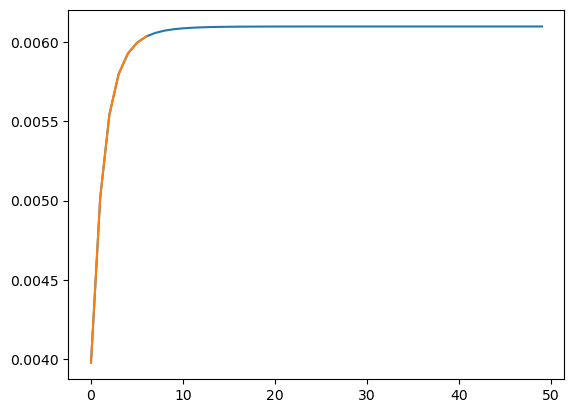

In [14]:
from src.hmm import forward, update_transition_matrix_from_parallel_smoothing, parallel_smoothing
import numpy as np
import matplotlib.pyplot as plt

initial_conditions = np.asarray([0.2, 0.8])
transition_matrix = np.asarray([[0.5, 0.5], [0.3, 0.7]])
emission_matrix = np.asarray([[0.3, 0.7], [0.8, 0.2]])

observations = np.asarray(["N", "N", "N", "N", "N", "E", "E", "N", "N", "N"])
observations_ind = np.asarray([0 if o == "N" else 1 for o in observations])
likelihood = emission_matrix[:, observations_ind].T

dll = []

for _ in range(50):
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, observations_ind, emission_matrix, transition_matrix
    )

    backward_posterior = parallel_smoothing(
        initial_conditions, observations_ind, emission_matrix, transition_matrix, scaling
    )

    transition_matrix = update_transition_matrix_from_parallel_smoothing(
        causal_posterior,
        backward_posterior,
        likelihood,
        transition_matrix,
        data_log_likelihood,
    )
    dll.append(data_log_likelihood)
    

plt.plot(np.exp(dll))
plt.plot(np.exp(model.monitor_.history))

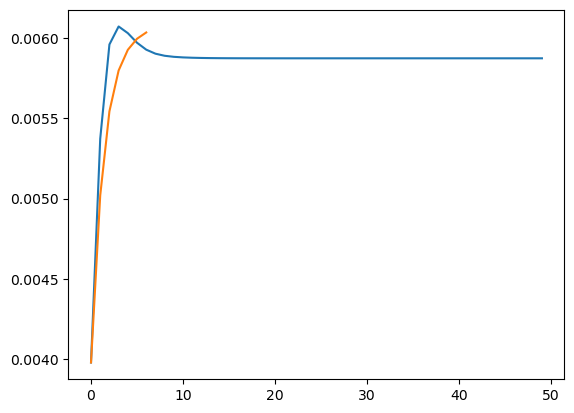

In [16]:
from src.hmm import forward, correction_smoothing, update_transition_matrix_from_correction_smoothing
import numpy as np
import matplotlib.pyplot as plt

initial_conditions = np.asarray([0.2, 0.8])
transition_matrix = np.asarray([[0.5, 0.5], [0.3, 0.7]])
emission_matrix = np.asarray([[0.3, 0.7], [0.8, 0.2]])

observations = np.asarray(["N", "N", "N", "N", "N", "E", "E", "N", "N", "N"])
observations_ind = np.asarray([0 if o == "N" else 1 for o in observations])
likelihood = emission_matrix[:, observations_ind].T

dll = []

for _ in range(50):
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, observations_ind, emission_matrix, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )
    dll.append(data_log_likelihood)
    
plt.plot(np.exp(dll))
plt.plot(np.exp(model.monitor_.history))